## Machine Learning: bikeshare data for Capstone 1

### Build a model

- Predict demand (# of rentals) on a given day (e.g. for 2017) 
    - linear regression/SVM
    - X: julian day; y: count/day
    - could add X: proximity to metro station <-- but is this redundant with station? could use for interpretation

#### Model steps: 
  - We can use older data to train (e.g. 2015-2016) and the most recent year to test accuracy (2017)
      - typical cross validation techniques will lead to spurious scoring becuase we are working with time series data
  - initialize a model (e.g. linear regression) and fit with training data
  - compare accuracy to test data visually

In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [10]:
totals = pd.read_csv('../CapstoneDrafts/data/2016totals.csv', 
                        parse_dates=True, index_col=4)
totals.head()

,Unnamed: 0,Year,Month,Day,timeDelt,startweekday,totalRents,timeDelt_sq,holiday,station,...,startdate2,tmax_sq,tmin_sq,day_0,day_1,day_2,day_3,day_4,day_5,day_6
startdate,,,,,,,,,,,,,,,,,,,,,
2016-01-01,0,2016,1,1,0,4,3220,0,0.0,USC00186350,...,2016-01-01,3136.0,1681.0,0,0,0,0,1,0,0
2016-01-02,1,2016,1,2,1,5,4921,1,0.0,USC00186350,...,2016-01-02,2116.0,961.0,0,0,0,0,0,1,0
2016-01-03,2,2016,1,3,2,6,4965,4,0.0,USC00186350,...,2016-01-03,2304.0,841.0,0,0,0,0,0,0,1
2016-01-04,3,2016,1,4,3,0,5133,9,0.0,USC00186350,...,2016-01-04,2809.0,841.0,1,0,0,0,0,0,0
2016-01-05,4,2016,1,5,4,1,4850,16,0.0,USC00186350,...,2016-01-05,1444.0,225.0,0,1,0,0,0,0,0


In [11]:
#eliminate extraneous columns before proceeding
X_main=totals.drop(['totalRents','station','name','startdate2'], axis=1)
y = totals['totalRents']

Attempt 3 increasingly complex models with basic linear model:

__Model 1__: Time and time<sup>2</sup> (_2 features_)

In [12]:
X1 = totals[['timeDelt', 'timeDelt_sq']]
y = totals['totalRents']

In [13]:
lr1 = LinearRegression(normalize=True)
lr1.fit(X1, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [14]:
scores1 = cross_val_score(lr1, X1, y, cv=5, scoring='r2')
print('r2 scores:', scores1)
print('mean r2:',np.mean(scores1))

r2 scores: [-0.2414031  -0.20546794 -0.12677024 -0.26390144 -0.29435678]
mean r2: -0.226379900519


This model including only the day of the year and the day of the year squared explains 22% of the variation in daily rentals. 

__Model 2__: Time, time<sup>2</sup>, daily max temp, and daily min temp, and min/max temp squared (_6 features_)

In [15]:
# model with daily mininum and maximum temperatures 
X2 = totals[['timeDelt', 'timeDelt_sq','tmax', 'tmin','tmax_sq','tmin_sq']]

In [16]:
lr2 = LinearRegression(normalize=True)
lr2.fit(X2, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [17]:
scores2 = cross_val_score(lr2, X2, y, cv=5, scoring='r2')
print('r2 scores:', scores2)
print('mean r2:',np.mean(scores2))

r2 scores: [-0.62169818 -0.21154754 -0.0877183  -0.19531387  0.0230425 ]
mean r2: -0.218647078539


This model also includes daily maximum and minimum temperature, and seems to only explain 21% of the variance.

__Model 3__: Time, time<sup>2</sup>, daily max temp, daily min temp, square of daily min/max temp, day of the week (7 dummy variables), holiday indicator (_14 features_)

In [18]:
## model with daily mininum and maximum temperatures, weekday dummies, and holiday indicator
X3 = totals[['timeDelt', 'timeDelt_sq','tmax', 'tmin','tmax_sq','tmax_sq',
             'day_0','day_1','day_2','day_3','day_4','day_5','holiday']]

In [19]:
lr3 = LinearRegression(normalize=True)
lr3.fit(X3, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [20]:
scores3 = cross_val_score(lr3, X3, y, cv=5, scoring='r2')
print('r2 scores:', scores3)
print('mean r2:', np.mean(scores3))

r2 scores: [-0.47328877 -0.01040266 -0.12089005 -0.15325834  0.07529169]
mean r2: -0.136509627096


This final model that includes the day of the week and holiday indicator seems to be the worst predictor of daily totals only explaining 13% of the variance. 

#### Model comparison and predictions
After calling ```.predict``` on the three models above, let's plot the actual 2016 and the predicted values from the models.

In [21]:
#predictions
totals['predicted1'] = lr1.predict(X1)
totals['predicted2'] = lr2.predict(X2)
totals['predicted3'] = lr3.predict(X3)

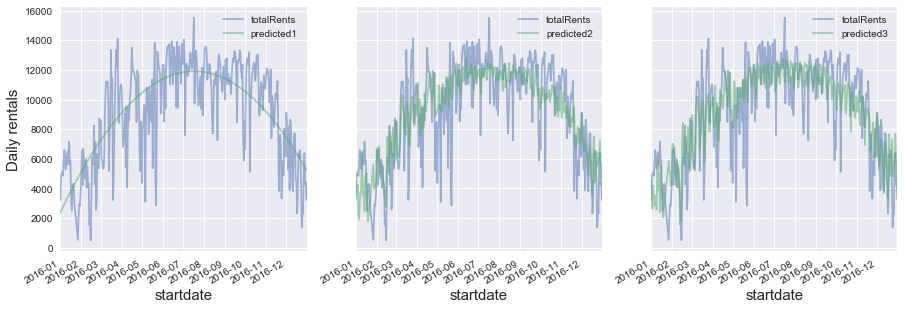

In [22]:
#predicted vs. actual plots
fig, axes = plt.subplots(1,3, sharey=True)
fig.set_size_inches(15,5)
axes[0].set_ylabel('Daily rentals',fontsize=15)
axes[0].set_xlabel('Day of the year (1 to 365)',fontsize=15)
axes[1].set_xlabel('Day of the year (1 to 365)',fontsize=15)
axes[2].set_xlabel('Day of the year (1 to 365)',fontsize=15)
totals[['totalRents', 'predicted1']].plot(alpha=0.5, ax=axes[0])
totals[['totalRents', 'predicted2']].plot(alpha=0.5, ax=axes[1])
totals[['totalRents', 'predicted3']].plot(alpha=0.5, ax=axes[2])

In [23]:
params = pd.Series(lr3.coef_, index=X3.columns)
params

timeDelt         60.320358
timeDelt_sq      -0.151899
tmax            214.167351
tmin            -37.845908
tmax_sq          -0.429639
tmax_sq          -0.429639
day_0           861.686477
day_1          1442.254966
day_2          1567.654457
day_3          1318.314488
day_4          1496.170624
day_5           545.952196
holiday           0.000000
dtype: float64

Attempt Ridge Regression:

In [41]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(normalize=True, store_cv_values=True)

In [42]:
ridge

RidgeCV(alphas=(0.1, 1.0, 10.0), cv=None, fit_intercept=True, gcv_mode=None,
    normalize=True, scoring=None, store_cv_values=True)

In [43]:
ridge.fit(X3, y)

RidgeCV(alphas=(0.1, 1.0, 10.0), cv=None, fit_intercept=True, gcv_mode=None,
    normalize=True, scoring=None, store_cv_values=True)

In [44]:
ridge.cv_values_

array([[ 16460060.59541451,  19639945.34845772,  29331384.00473665],
       [    69047.34307402,   1538589.17451609,  10699479.48789551],
       [   101967.39217307,   2312375.01686958,  10981894.03737218],
       ..., 
       [  7532457.90054946,  10069971.31401723,  18813171.61980489],
       [  7336295.40652151,   9590046.25097923,  17499924.36583484],
       [  4902297.14267687,   9882593.74596198,  25797118.67591717]])

In [45]:
ridge.alpha_

0.10000000000000001